In [1]:
%cd ../
%pwd

D:\Source\IndTB_ppa


'D:\\Source\\IndTB_ppa'

In [2]:
import json
import pandas as pd
import numpy as np
import scipy.stats as sts

In [3]:
def rbinom(n, p):
    return sts.binom.rvs(n=n, p=p)

def runif(a, b):
    return sts.uniform.rvs(loc=a, scale=b - a)

In [4]:
dat = pd.read_csv('data/cascade/d_cascade_2019.csv').set_index('State')

dat = {i: row.to_dict() for i, row in dat.iterrows()}

In [5]:
dat.keys()

dict_keys(['India', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh', 'Delhi', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'])

In [6]:
d = dat['India']
d

{'Region': 'India',
 'N': 322480,
 'PrevUt': 278.1567847885141,
 'PrevTx': 183.63439911095264,
 'Pr_Pub_CSI': 0.4962686567164179,
 'Pr_Pub_CSI0': 0.636,
 'Pr_Pub_CSI1': 0.640625,
 'Pr_Asym': 0.6327231121281465,
 'Pr_NotAware': 0.2072824237267533,
 'Pr_NotCS': 0.0318080445616501,
 'Pr_NotDet': 0.12818641958345,
 'Pop': 1357660000,
 'CNR_pub': 0.00127,
 'CNR_eng': 0.0005,
 'TxI_pub': 0.94,
 'TxI_eng': 0.95,
 'TxSucc_pub': 0.9032258064516128,
 'TxSucc_eng': 0.9102564102564102,
 'TxDead_pub': 0.043010752688172,
 'TxDead_eng': 0.0256410256410256,
 'TxLTFU_pub': 0.053763440860215,
 'TxLTFU_eng': 0.0641025641025641}

In [88]:
settings = {
    'r_succ_pub': 2, 
    'r_succ_eng': 2,
    'rr_ltfu_pri': 1.5,
    'ppv_pub': 0.85
}

prior = {
    'r_die_untx': runif(0.14, 0.18),
    'r_sc': runif(0.1, 0.3),
    'rr_die_asym': runif(0, 1),
    'TxI_pri': runif(0.5, 1),
    'dur_succ_pri': runif(2 / 12, 9 / 12),
    'ppv_pri': runif(0.2, 1),
    'det_pri': runif(0.0001, 0.01)
}

prior, settings 

({'r_die_untx': 0.1798689511083642,
  'r_sc': 0.12024928001583607,
  'rr_die_asym': 0.5096196430571074,
  'TxI_pri': 0.8545385730070815,
  'dur_succ_pri': 0.4209224873785763,
  'ppv_pri': 0.36876161776891414,
  'det_pri': 0.0013696519838913134},
 {'r_succ_pub': 2, 'r_succ_eng': 2, 'rr_ltfu_pri': 1.5, 'ppv_pub': 0.85})

In [259]:
class Tx:
    def __init__(self, d, s, exo):
        d = dict(d)
        d.update(s)
        d.update(exo)
        self.Pars = exo
        self.R_succ_tx = np.array([d['r_succ_pub'], d['r_succ_eng'], 1 / d['dur_succ_pri']])
        ltfu = np.array([d['TxLTFU_pub'], d['TxLTFU_eng'], d['TxLTFU_eng'] * d['rr_ltfu_pri']])
        die = np.array([d['TxDead_pub'], d['TxDead_eng'], d['TxDead_eng']])
        succ = np.array([d['TxSucc_pub'], d['TxSucc_eng'], d['TxSucc_eng']])
        self.R_ltfu_tx = self.R_succ_tx * ltfu / succ
        self.R_die_tx = self.R_succ_tx * die / succ
        self.DetR = np.array([d['CNR_pub'], d['CNR_eng'], d['det_pri']]) 
        self.TxR = self.DetR * np.array([d['TxI_pub'], d['TxI_eng'], d['TxI_pri']])
        self.PPV = np.array([d['ppv_pub'], d['ppv_pub'], d['ppv_pri']])
        prev_tx = self.TxR / (self.R_ltfu_tx + self.R_die_tx + self.R_succ_tx) / self.PPV
        self.PrevTx = prev_tx
        self.ExPrevTx = rbinom(d['Pop'], d['PrevTx'] * 1e-5) / d['Pop'],
        self.PrPri = prev_tx[1:].sum() / prev_tx.sum()
        self.PrPri0 = prev_tx[1].sum() / prev_tx[:2].sum()
        
    def distance(self):
        return np.power(m.PrevTx.sum() / m.ExPrevTx - 1, 2) * 100 + np.power(m.PrPri0 / 0.4 - 1, 2)
        
    def summary(self, key=0):
        dur = 1 / (self.R_ltfu_tx + self.R_die_tx + self.R_succ_tx)

        su = {
            'Key': key,
            'PrevTxPub': self.PrevTx[0], 
            'PrevTxEng': self.PrevTx[1], 
            'PrevTxPri': self.PrevTx[2],
            'DurTxPub': dur[0],
            'DurTxEng': dur[1],
            'DurTxPri': dur[2],
            'PrPri': self.PrPri,
            'PrPri0': self.PrPri0,
            'PriVsPub': dur[0] / dur[1:].sum()
        }

        su.update(self.Pars)
        return su

m = Tx(d, settings, prior)
m.PrevTx.sum(), m.distance()

(0.01119213726336387, array([2597.11796411]))

In [260]:
np.power(m.PrevTx.sum() / m.ExPrevTx - 1, 2) * 100, np.power(m.PrPri0 - 0.4, 2)

(array([2597.03704819]), 0.012946547696626013)

In [261]:
dis = []

while len(dis) < 1000:
    prior = {
        'r_die_untx': runif( 0.14, 0.18),
        'r_sc': runif(0.1, 0.3),
        'rr_die_asym': runif(0, 1),
        'TxI_pri': 0.8,
        'dur_succ_pri': runif(2 / 12, 9 / 12),
        'ppv_pri': runif(0.2, 1),
        'det_pri': runif(0.0001, 0.01)
    }
    m = Tx(d, settings, prior)
    dis.append(m.distance())

eps = np.quantile(dis, 0.02)
eps

0.13565602059200302

In [262]:
ms = []

n_sim = 0
while len(ms) < 1000:
    n_sim += 1
    prior = {
        'r_die_untx': runif( 0.14, 0.18),
        'r_sc': runif(0.1, 0.3),
        'rr_die_asym': runif(0, 1),
        'TxI_pri': runif(0.5, 1),
        'dur_succ_pri': runif(2 / 12, 9 / 12),
        'ppv_pri': runif(0.2, 1),
        'det_pri': runif(0.0001, 0.01)
    }
    m = Tx(d, settings, prior)
    if m.distance() < eps:
        ms.append(m)
        
res = [m.summary(i) for i, m in enumerate(ms)]
res = pd.DataFrame(res).set_index('Key')
        
acc = 1000 / n_sim
acc, n_sim

(0.020314055294858514, 49227)

In [245]:
res

,PrevTxPub,PrevTxEng,PrevTxPri,DurTxPub,DurTxEng,DurTxPri,PrPri,PrPri0,PriVsPub,r_die_untx,r_sc,rr_die_asym,TxI_pri,dur_succ_pri,ppv_pri,det_pri
Key,,,,,,,,,,,,,,,,
0,0.000634,0.000254,0.000627,0.451613,0.455128,0.171259,0.581603,0.286217,0.720980,0.179572,0.180899,0.838307,0.558912,0.194174,0.963546,0.006315
1,0.000634,0.000254,0.001467,0.451613,0.455128,0.334270,0.730717,0.286217,0.572097,0.153575,0.273532,0.391231,0.754858,0.378997,0.743864,0.004324
2,0.000634,0.000254,0.001512,0.451613,0.455128,0.314651,0.735817,0.286217,0.586679,0.179465,0.246342,0.862549,0.605582,0.356752,0.892698,0.007085
3,0.000634,0.000254,0.000827,0.451613,0.455128,0.442407,0.630376,0.286217,0.503170,0.160856,0.152391,0.982697,0.637622,0.501603,0.470212,0.001379
4,0.000634,0.000254,0.001261,0.451613,0.455128,0.423450,0.704924,0.286217,0.514027,0.147058,0.239466,0.686369,0.709996,0.480109,0.841945,0.003531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000634,0.000254,0.000447,0.451613,0.455128,0.634477,0.525271,0.286217,0.414474,0.150759,0.214106,0.247191,0.568191,0.719372,0.916516,0.001138
996,0.000634,0.000254,0.000501,0.451613,0.455128,0.260552,0.543654,0.286217,0.631026,0.146689,0.159024,0.110827,0.524289,0.295415,0.643358,0.002361
997,0.000634,0.000254,0.001363,0.451613,0.455128,0.190662,0.718252,0.286217,0.699318,0.165009,0.137688,0.848835,0.700540,0.216173,0.597195,0.006092


In [100]:
#res.to_csv('out/dur.csv')

In [189]:
import matplotlib.pyplot as plt

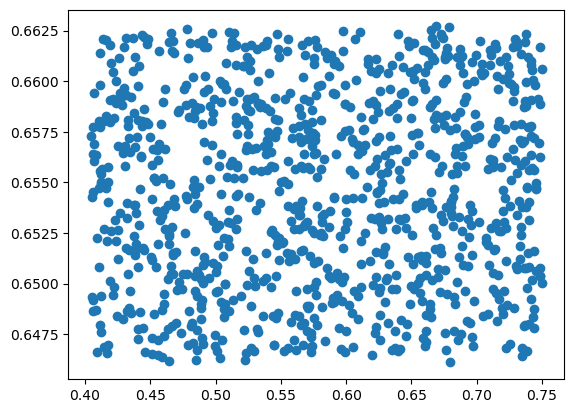

In [263]:
plt.scatter(res.PriVsPub, res.PrPri)
plt.show()